In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# abbreviation for plotting functions in certain range
def plot(f, xRange, *args, **kw):
    yRange = np.fromiter(map(f,xRange), np.float)
    plt.plot(xRange,yRange, *args, **kw)

System is $A\leftrightarrow B$ with rates $\kappa_1$ and $\kappa_2$. There is only 1 particle at a time, thus we have a simple two state system, what switches with the given rates. Our method should be able to get these

In [18]:
import generate_tools.kinetic_monte_carlo as kmc

n_species = 2
n_boxes = 1
rate_1 = 1.
rate_2 = 2.
diffusivity_a = np.array([[0.]])
diffusivity_b = np.array([[0.]])
diffusivity = np.array([diffusivity_a, diffusivity_b])
init_state = np.array([[1, 0]])
species_names = ["A", "B"]
system = kmc.ReactionDiffusionSystem(diffusivity, n_species, n_boxes, init_state, species_names=species_names)
system.add_conversion("A", "B", np.array([rate_1]))
system.add_conversion("B", "A", np.array([rate_2]))
system.simulate(50)

[KMC] [2017-07-02 19:21:38] [INFO] Simulate for 50 steps


In [19]:
def get_counts_config(n_frames):
    counts, times = system.convert_events_to_time_series(n_frames=n_frames)
    # flatten out spatial dimension and convert to float
    counts = np.sum(counts, axis=1, dtype=np.float64)
    config = system.get_trajectory_config()
    return counts, times, config

counts, times, config = get_counts_config(50000)

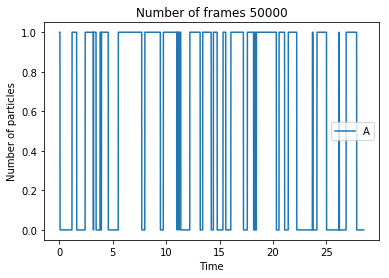

In [20]:
def plot_counts(counts, times, config):
    plt.plot(times, counts[:, config.types["A"]], label="A")
    #plt.plot(times, counts[:, config.types["B"]], label="B")
    #plot(lambda x: analytic_model_a(x, 2.), 
    #     times, label=r"true model $a(t) = \frac{a(0)}{1 + a(0)\, \kappa\, t}$")
    plt.legend(loc="best")
    plt.xlabel("Time")
    plt.ylabel("Number of particles")
    plt.title("Number of frames " + str(len(counts)))

plot_counts(counts, times, config)

## readdy_learn

In [21]:
counts = counts
times = times

In [22]:
# Trajectory object
import py_analyze_tools.tools as pat

traj = pat.Trajectory.from_counts(config, counts, times[1]-times[0])
traj.update()

# Basis functions
from py_analyze_tools.sklearn import BasisFunctionConfiguration

bfc = BasisFunctionConfiguration(n_species=traj.n_species)
bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(1, 0) # B -> A
right_rates = np.array([rate_1, rate_2])

# Estimate
from py_analyze_tools.sklearn import ReaDDyElasticNetEstimator

est = ReaDDyElasticNetEstimator(traj, bfc, 1., 
                                alpha=0., l1_ratio=1., method=None,
                                verbose=True, approx_jac=False, options={'ftol': 1e-12})
est.fit(None)
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)
print("right rates =%s" % right_rates)

max counts = 1.0, min nonzero counts = 1.0
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
4 / 15000 iterations
coefficients=[ 0.02970284  0.        ]
right rates =[ 1.  2.]


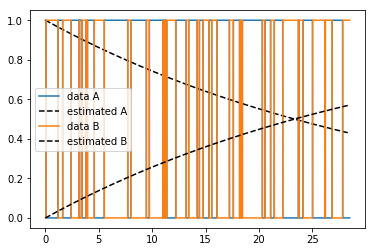

In [23]:
from scipy.integrate import odeint

def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(coefficients, theta)

estimated_realisation = odeint(fun, traj.counts[0], np.arange(0., traj.n_time_steps*traj.time_step, traj.time_step))
for t in ["A", "B"]:
    type_id = config.types[t]
    plt.plot(times, traj.counts[:, type_id], label="data "+t)
    plt.plot(times, estimated_realisation[:, type_id], "k--", label="estimated "+t)
    plt.legend(loc="best")

plt.show()

### Get the waiting times of events and do a histogram

In [14]:
event_list, time_list, state_list = system.sequence

In [15]:
time_deltas = np.array(time_list)[1:] - np.array(time_list)[0:-1]
print(time_deltas)

[ 0.00747239  1.28254838  0.81267194 ...,  0.26290745  0.64666778
  0.57982905]


In [16]:
ab_deltas = time_deltas[::2]
ba_deltas = time_deltas[1::2]
print(ab_deltas)
print(ba_deltas)

[ 0.00747239  0.81267194  0.17445529 ...,  0.12515252  0.17318033
  0.64666778]
[ 1.28254838  0.11442871  1.16235572 ...,  0.69042228  0.26290745
  0.57982905]


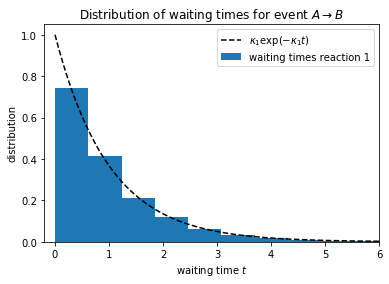

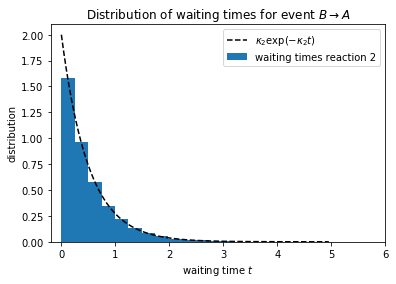

In [17]:
_, bins, _ = plt.hist(ab_deltas, bins=20, normed=True, label=r"waiting times reaction 1")
plot(lambda x: np.exp(-1.*x), np.linspace(bins[0], bins[-1], 1000), "k--", label=r"$\kappa_1\exp(-\kappa_1 t)$")
plt.legend(loc="best")
plt.xlabel("waiting time $t$")
plt.ylabel("distribution")
plt.title(r"Distribution of waiting times for event $A\rightarrow B$")
plt.xlim((-0.2,6.))
plt.show()

_, bins, _ = plt.hist(ba_deltas, bins=20, normed=True, label=r"waiting times reaction 2")
plot(lambda x: 2.*np.exp(-2.*x), np.linspace(bins[0], bins[-1], 1000), "k--", label=r"$\kappa_2\exp(-\kappa_2 t)$")
plt.legend(loc="best")
plt.xlabel("waiting time $t$")
plt.ylabel("distribution")
plt.title(r"Distribution of waiting times for event $B\rightarrow A$")
plt.xlim((-0.2,6.))
plt.show()

__The correct rates are indeed encoded in the waiting times !__